In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn.modules.loss import *
from Loss.triplet import *
from session import *
from LR_Schedule.cyclical import Cyclical
from LR_Schedule.cos_anneal import CosAnneal
from LR_Schedule.lr_find import lr_find
from callbacks import *
from validation import *
from validation import _AccuracyMeter
import Datasets.ImageData as ImageData
from Transforms.ImageTransforms import *
import util
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from torch.utils.tensorboard import SummaryWriter
from session import LossMeter, EvalModel
# %matplotlib notebook

/home/drake/anaconda3/envs/.torch/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/drake/anaconda3/envs/.torch/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/drake/anaconda3/envs/.torch/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/drake/anaconda3/envs/.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
torch.cuda.set_device(0); torch.backends.cudnn.benchmark=True;

/home/drake/anaconda3/envs/.torch/lib/python3.7/site-packages/torch/cuda/__init__.py:135: UserWarning: 
    Found GPU0 GeForce GTX 770 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


In [4]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

fulltrainset = torchvision.datasets.CIFAR10(root='/media/drake/MX500/Datasets/cifar-10/train', train=True,
                                        download=True, transform=transform)
trainset = torch.utils.data.dataset.Subset(fulltrainset, np.arange(6400))

fullvalset = torchvision.datasets.CIFAR10(root='/media/drake/MX500/Datasets/cifar-10/test', train=False,
                                       download=True, transform=transform)
valset = torch.utils.data.dataset.Subset(fullvalset, np.arange(6400))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [6]:
class TripletRegularizedCrossEntropyLoss(nn.Module):
    def __init__(self, alpha, margin):     
        super().__init__()
        self.alpha = alpha
        self.margin = margin
        
    def forward(self, x, y):
        loss = F.cross_entropy(x[-1][0], y)
        triplet = 0
        if (self.alpha > 0):
            for layer in x[:-1]:
                # print(layer[0])
                triplet += batch_hard_triplet_loss(layer[0].view(layer[0].size(0), -1), y, self.margin)

            triplet *= self.alpha
            
        return loss + triplet

In [7]:
class CustomOneHotAccuracy(OneHotAccuracy):
    def __init__(self):
        super().__init__()
        self.reset()

    def update(self, output, label):
        return super().update(output[-1][0], label)

In [8]:
class EmbeddingSpaceValidator(TrainCallback):
    def __init__(self, val_data, num_embeddings, accuracy_meter_fn):
        self.val_data = val_data
        self.val_accuracy_meter = accuracy_meter_fn()
        self.train_accuracy_meter = accuracy_meter_fn()
        self.num_embeddings=num_embeddings
        
        self.train_accuracies = []
        self.batch_train_accuracies = []
        self.val_accuracies = []
        
        self.train_losses = []
        self.batch_train_losses = []
        self.train_bce_losses = []
        self.val_losses = []
        self.val_bce_losses = []
        
        self.batch_train_embedding_losses = [[] for x in range(self.num_embeddings)]
        self.val_embedding_losses = [[] for x in range(self.num_embeddings)]
        
        self.num_batches = 0
        self.num_epochs = 0
        
        self.epochs = []

    def run(self, session, lossMeter=None):
        self.val_accuracy_meter.reset()
            
        val_loss = LossMeter()
        val_bce_loss = LossMeter()
        embedding_losses = [LossMeter() for x in range(self.num_embeddings)]
        
        with EvalModel(session.model):
            for input, label, *_ in tqdm(self.val_data, desc="Validating", leave=True):
                label = Variable(util.to_gpu(label))
                output = session.forward(input)
                
                step_loss = session.criterion(output, label).data.cpu()
                
                val_loss.update(step_loss, input.shape[0])
                
                val_bce_loss.update(F.cross_entropy(output[-1][0], label).data.cpu(), input.shape[0])
                
                self.val_accuracy_meter.update(output, label)
                    
                for layer, embedding_loss in zip(output[:-1], embedding_losses):
                    embedding_loss.update(batch_all_triplet_loss(layer[0].view(layer[0].size(0), -1), label, 1).data.cpu())
        
        self.val_losses.append(val_loss.raw_avg.item())
        self.val_bce_losses.append(val_bce_loss.raw_avg.item())
         
        accuracy = self.val_accuracy_meter.accuracy()
        
        self.val_accuracies.append(accuracy)
              
        for meter, loss in zip(embedding_losses, self.val_embedding_losses):
            loss.append(meter.raw_avg)     
        
    def on_epoch_begin(self, session):
        self.train_accuracy_meter.reset()     
        self.train_bce_loss_meter = LossMeter()
        
    def on_epoch_end(self, session, lossMeter): 
        self.train_accuracies.append(self.train_accuracy_meter.accuracy())
        self.train_losses.append(lossMeter.debias.data.cpu().item())
        
        self.train_bce_losses.append(self.train_bce_loss_meter.raw_avg.data.cpu().item())
        
        self.run(session, lossMeter) 
        self.epochs.append(self.num_batches)
        self.num_epochs += 1
        
        print("\nval accuracy: ", round(self.val_accuracies[-1], 4),
              "\ntrain loss: ", round(self.train_losses[-1], 4) , 
              " train BCE : ", round(self.train_bce_losses[-1], 4) ,       
              "\nvalid loss: ", round(self.val_losses[-1], 4), 
              " valid BCE : ", round(self.val_bce_losses[-1], 4))
    
    def on_batch_end(self, session, lossMeter, output, label):
        label = Variable(util.to_gpu(label))
        batch_accuracy = self.train_accuracy_meter.update(output, label)
        self.batch_train_accuracies.append(batch_accuracy)
        self.batch_train_losses.append(lossMeter.loss.data.cpu().item())   
        self.train_bce_loss_meter.update(F.cross_entropy(output[-1][0], label).data.cpu(), label.shape[0])
             
        for layer, embedding_loss in zip(output[:-1], self.batch_train_embedding_losses):
            embedding_loss.append(batch_all_triplet_loss(layer[0].view(layer[0].size(0), -1), label, 1).data.cpu().item())
            
        self.num_batches += 1
            
    def plot(self):
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(15, 15))
        
        #ax.plot(np.arange(self.num_batches), self.batch_train_accuracies)
        #legend.append("Train accuracy per batch")
        
        #ax.plot(np.arange(self.num_batches), self.batch_train_losses)
        #legend.append("Train loss per batch")
            
        ax1.plot(self.epochs, self.train_accuracies, '-o', label="Training accuracy per epoch")

        ax1.plot(self.epochs, self.val_accuracies, '-o', label="Validation accuracy per epoch")
        
        ax2.plot(self.epochs, self.train_losses, '-o', label="Training loss per epoch")
        
        ax2.plot(self.epochs, self.val_losses, '-o', label="Validation loss per epoch")
        
        ax3.plot(self.epochs, self.train_bce_losses, '-o', label="Training BCE loss per epoch")
        
        ax3.plot(self.epochs, self.val_bce_losses, '-o', label="Validation BCE loss per epoch")
        
        for embedding in self.batch_train_embedding_losses:
            ax4.plot(np.arange(self.num_batches), embedding, label="Train embedding triplet loss per batch")
        
        for embedding in self.val_embedding_losses:
            ax4.plot(self.epochs, embedding, '-o', label="Validation embedding triplet loss per epoch")
            
        for ax in (ax1, ax2, ax3, ax4):
            box = ax.get_position()
            ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))   

In [9]:
class SelectiveSequential(nn.Module):
    def __init__(self, to_select, modules_dict):
        super(SelectiveSequential, self).__init__()
        for key, module in modules_dict.items():
            self.add_module(key, module)
        self._to_select = to_select
    
    def forward(self, x):
        list = []
        for name, module in self._modules.items():
            x = module(x)
            if name in self._to_select:
                list.append((x, name))
        return list

In [10]:
resnet = torchvision.models.resnet18(pretrained=False)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Sequential()

#model = SelectiveSequential(
#    ['act1', 'act2', 'out'],
#    {'conv32a': resnet,
#       
#     'fc1': nn.Linear(num_ftrs, 1000),
#     'act1': nn.ReLU(True),
#     #'drop1': nn.Dropout(.05),
#     'fc2': nn.Linear(1000, 1000),
#     'act2': nn.ReLU(True),
#     #'drop1': nn.Dropout(.05),
#     'out': nn.Linear(1000, 10)})

model = SelectiveSequential(
    ['act1', 'act2', 'out'],
    {'conv32a': nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
     #'batch32a': nn.BatchNorm2d(32),
     'act32a': nn.ReLU(True),
    
     'conv32b': nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
     #'batch32b': nn.BatchNorm2d(32),
     'act32b': nn.ReLU(True),
     
     'max1': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'conv64a': nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
     #'batch64a': nn.BatchNorm2d(64),
     'act64a': nn.ReLU(True),
     
     'conv64b': nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
     #'batch64b': nn.BatchNorm2d(64),
     'act64b': nn.ReLU(True),
    
     'max2': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'conv128a': nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
     #'batch128a': nn.BatchNorm2d(128),
     'act128a': nn.ReLU(True),
     
     'conv128b': nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
     #'batch128b': nn.BatchNorm2d(128),
     'act128b': nn.ReLU(True),
     
     'max3': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'flatten': Flatten(),
    
     'fc1': nn.Linear(4 * 4 * 128, 512),
     'act1': nn.ReLU(True),
     #'drop1': nn.Dropout(.05),
     'fc2': nn.Linear(512, 256),
     'act2': nn.ReLU(True),
     #'drop1': nn.Dropout(.05),
     'out': nn.Linear(256, 10)})

In [11]:
criterion = TripletRegularizedCrossEntropyLoss(0, .5)

In [12]:
sess = Session(model, criterion, optim.AdamW, 1e-4)

In [13]:
validator = EmbeddingSpaceValidator(valloader, 2, CustomOneHotAccuracy)
lr_scheduler = CosAnneal(len(trainloader) * 60, T_mult=1, lr_min=1e-7)
schedule = TrainingSchedule(trainloader, [lr_scheduler, validator])
sess.train(schedule, 60)

Validating: 100%|██████████| 200/200 [00:02<00:00, 68.46it/s]


val accuracy:  0.2853 
train loss:  2.0336  train BCE :  2.136 
valid loss:  1.968  valid BCE :  1.968


Validating: 100%|██████████| 200/200 [00:02<00:00, 69.69it/s]


val accuracy:  0.322 
train loss:  1.7854  train BCE :  1.8486 
valid loss:  1.8067  valid BCE :  1.8067


Validating: 100%|██████████| 200/200 [00:02<00:00, 66.93it/s]


val accuracy:  0.4056 
train loss:  1.6276  train BCE :  1.6746 
valid loss:  1.6323  valid BCE :  1.6323


Validating: 100%|██████████| 200/200 [00:03<00:00, 61.74it/s]


val accuracy:  0.415 
train loss:  1.5886  train BCE :  1.5985 
valid loss:  1.6193  valid BCE :  1.6193


Validating: 100%|██████████| 200/200 [00:03<00:00, 62.35it/s]



val accuracy:  0.4267 
train loss:  1.5241  train BCE :  1.517 
valid loss:  1.5412  valid BCE :  1.5412


Validating: 100%|██████████| 200/200 [00:03<00:00, 64.64it/s]


val accuracy:  0.4428 
train loss:  1.4717  train BCE :  1.4759 
valid loss:  1.5211  valid BCE :  1.5211


Validating: 100%|██████████| 200/200 [00:02<00:00, 67.59it/s]


val accuracy:  0.4628 
train loss:  1.4178  train BCE :  1.4039 
valid loss:  1.4696  valid BCE :  1.4696


Validating: 100%|██████████| 200/200 [00:02<00:00, 67.96it/s]


val accuracy:  0.4648 
train loss:  1.3744  train BCE :  1.3686 
valid loss:  1.464  valid BCE :  1.464


Validating: 100%|██████████| 200/200 [00:02<00:00, 68.15it/s]


val accuracy:  0.4783 
train loss:  1.3246  train BCE :  1.3228 
valid loss:  1.4359  valid BCE :  1.4359


Validating: 100%|██████████| 200/200 [00:02<00:00, 68.26it/s]


val accuracy:  0.4803 
train loss:  1.2609  train BCE :  1.2592 
valid loss:  1.4242  valid BCE :  1.4242


Validating: 100%|██████████| 200/200 [00:03<00:00, 66.56it/s]


val accuracy:  0.4925 
train loss:  1.2246  train BCE :  1.2104 
valid loss:  1.4071  valid BCE :  1.4071


Validating: 100%|██████████| 200/200 [00:02<00:00, 67.67it/s]


val accuracy:  0.4909 
train loss:  1.1637  train BCE :  1.149 
valid loss:  1.4237  valid BCE :  1.4237


Validating: 100%|██████████| 200/200 [00:03<00:00, 66.59it/s]


val accuracy:  0.5069 
train loss:  1.0812  train BCE :  1.101 
valid loss:  1.412  valid BCE :  1.412


Validating: 100%|██████████| 200/200 [00:03<00:00, 63.06it/s]


val accuracy:  0.5019 
train loss:  1.0454  train BCE :  1.0406 
valid loss:  1.4284  valid BCE :  1.4284


Validating: 100%|██████████| 200/200 [00:02<00:00, 67.67it/s]


val accuracy:  0.5102 
train loss:  0.9858  train BCE :  0.9827 
valid loss:  1.4247  valid BCE :  1.4247


Validating: 100%|██████████| 200/200 [00:03<00:00, 64.07it/s]


val accuracy:  0.5216 
train loss:  0.9316  train BCE :  0.917 
valid loss:  1.4075  valid BCE :  1.4075


Validating: 100%|██████████| 200/200 [00:03<00:00, 65.15it/s]


val accuracy:  0.5216 
train loss:  0.8733  train BCE :  0.8602 
valid loss:  1.4389  valid BCE :  1.4389


Validating: 100%|██████████| 200/200 [00:02<00:00, 67.41it/s]


val accuracy:  0.5125 
train loss:  0.7865  train BCE :  0.7747 
valid loss:  1.5098  valid BCE :  1.5098


Validating: 100%|██████████| 200/200 [00:02<00:00, 67.21it/s]


val accuracy:  0.5139 
train loss:  0.7208  train BCE :  0.705 
valid loss:  1.5437  valid BCE :  1.5437


Validating: 100%|██████████| 200/200 [00:03<00:00, 65.24it/s]


val accuracy:  0.507 
train loss:  0.6413  train BCE :  0.6251 
valid loss:  1.6753  valid BCE :  1.6753


Validating: 100%|██████████| 200/200 [00:02<00:00, 66.68it/s]


val accuracy:  0.5114 
train loss:  0.5759  train BCE :  0.5503 
valid loss:  1.7123  valid BCE :  1.7123


Validating: 100%|██████████| 200/200 [00:03<00:00, 63.33it/s]


val accuracy:  0.5133 
train loss:  0.4929  train BCE :  0.4683 
valid loss:  1.758  valid BCE :  1.758


Validating: 100%|██████████| 200/200 [00:02<00:00, 66.98it/s]


val accuracy:  0.5172 
train loss:  0.3758  train BCE :  0.3785 
valid loss:  1.933  valid BCE :  1.933


Validating: 100%|██████████| 200/200 [00:03<00:00, 65.58it/s]


val accuracy:  0.5188 
train loss:  0.3408  train BCE :  0.323 
valid loss:  2.0874  valid BCE :  2.0874


Validating: 100%|██████████| 200/200 [00:02<00:00, 67.19it/s]


val accuracy:  0.5158 
train loss:  0.2604  train BCE :  0.2485 
valid loss:  2.1901  valid BCE :  2.1901


Validating: 100%|██████████| 200/200 [00:03<00:00, 62.46it/s]


val accuracy:  0.5092 
train loss:  0.2166  train BCE :  0.1996 
valid loss:  2.4516  valid BCE :  2.4516


Validating: 100%|██████████| 200/200 [00:02<00:00, 68.03it/s]


val accuracy:  0.5062 
train loss:  0.1562  train BCE :  0.15 
valid loss:  2.6208  valid BCE :  2.6208


Validating: 100%|██████████| 200/200 [00:02<00:00, 67.36it/s]


val accuracy:  0.5102 
train loss:  0.111  train BCE :  0.1086 
valid loss:  2.8062  valid BCE :  2.8062


Validating: 100%|██████████| 200/200 [00:03<00:00, 64.38it/s]


val accuracy:  0.5084 
train loss:  0.0737  train BCE :  0.0712 
valid loss:  3.0959  valid BCE :  3.0959


Validating: 100%|██████████| 200/200 [00:03<00:00, 60.59it/s]


val accuracy:  0.5147 
train loss:  0.0446  train BCE :  0.0434 
valid loss:  3.2825  valid BCE :  3.2825


Validating: 100%|██████████| 200/200 [00:02<00:00, 68.23it/s]


val accuracy:  0.5084 
train loss:  0.0312  train BCE :  0.0277 
valid loss:  3.4964  valid BCE :  3.4964


Validating: 100%|██████████| 200/200 [00:02<00:00, 68.65it/s]


val accuracy:  0.5086 
train loss:  0.025  train BCE :  0.0229 
valid loss:  3.6889  valid BCE :  3.6889


Validating: 100%|██████████| 200/200 [00:02<00:00, 68.38it/s]


val accuracy:  0.51 
train loss:  0.0135  train BCE :  0.0156 
valid loss:  3.8766  valid BCE :  3.8766


Validating: 100%|██████████| 200/200 [00:03<00:00, 60.45it/s]


val accuracy:  0.4991 
train loss:  0.024  train BCE :  0.0149 
valid loss:  4.0514  valid BCE :  4.0514


Validating: 100%|██████████| 200/200 [00:02<00:00, 68.26it/s]


val accuracy:  0.5077 
train loss:  0.0424  train BCE :  0.0389 
valid loss:  4.0099  valid BCE :  4.0099


Validating: 100%|██████████| 200/200 [00:02<00:00, 67.66it/s]


val accuracy:  0.5112 
train loss:  0.0201  train BCE :  0.0318 
valid loss:  3.9256  valid BCE :  3.9256


Validating: 100%|██████████| 200/200 [00:03<00:00, 63.17it/s]



val accuracy:  0.5105 
train loss:  0.0073  train BCE :  0.0072 
valid loss:  4.2164  valid BCE :  4.2164


Validating: 100%|██████████| 200/200 [00:03<00:00, 62.38it/s]


val accuracy:  0.5106 
train loss:  0.0049  train BCE :  0.0057 
valid loss:  4.1922  valid BCE :  4.1922


Validating: 100%|██████████| 200/200 [00:02<00:00, 70.43it/s]


val accuracy:  0.5142 
train loss:  0.0038  train BCE :  0.0037 
valid loss:  4.3034  valid BCE :  4.3034


Validating: 100%|██████████| 200/200 [00:03<00:00, 66.53it/s]


val accuracy:  0.5127 
train loss:  0.0031  train BCE :  0.003 
valid loss:  4.3837  valid BCE :  4.3837


Validating: 100%|██████████| 200/200 [00:02<00:00, 68.09it/s]


val accuracy:  0.5128 
train loss:  0.0027  train BCE :  0.0026 
valid loss:  4.4616  valid BCE :  4.4616


Validating: 100%|██████████| 200/200 [00:02<00:00, 70.54it/s]


val accuracy:  0.512 
train loss:  0.0023  train BCE :  0.0023 
valid loss:  4.5268  valid BCE :  4.5268


Validating: 100%|██████████| 200/200 [00:03<00:00, 65.64it/s]


val accuracy:  0.5138 
train loss:  0.0021  train BCE :  0.0021 
valid loss:  4.5905  valid BCE :  4.5905


Validating: 100%|██████████| 200/200 [00:02<00:00, 69.22it/s]


val accuracy:  0.5141 
train loss:  0.002  train BCE :  0.0019 
valid loss:  4.6423  valid BCE :  4.6423


Validating: 100%|██████████| 200/200 [00:02<00:00, 67.31it/s]


val accuracy:  0.5122 
train loss:  0.0018  train BCE :  0.0017 
valid loss:  4.6869  valid BCE :  4.6869


Validating: 100%|██████████| 200/200 [00:02<00:00, 67.52it/s]


val accuracy:  0.513 
train loss:  0.0016  train BCE :  0.0016 
valid loss:  4.7339  valid BCE :  4.7339


Validating: 100%|██████████| 200/200 [00:02<00:00, 68.57it/s]


val accuracy:  0.5108 
train loss:  0.0015  train BCE :  0.0015 
valid loss:  4.7726  valid BCE :  4.7726


Validating: 100%|██████████| 200/200 [00:02<00:00, 68.26it/s]


val accuracy:  0.512 
train loss:  0.0015  train BCE :  0.0014 
valid loss:  4.815  valid BCE :  4.815


Validating: 100%|██████████| 200/200 [00:02<00:00, 69.83it/s]


val accuracy:  0.5122 
train loss:  0.0013  train BCE :  0.0013 
valid loss:  4.84  valid BCE :  4.84


Validating: 100%|██████████| 200/200 [00:02<00:00, 69.54it/s]


val accuracy:  0.5106 
train loss:  0.0012  train BCE :  0.0012 
valid loss:  4.8739  valid BCE :  4.8739


Validating: 100%|██████████| 200/200 [00:02<00:00, 68.62it/s]


val accuracy:  0.5134 
train loss:  0.0011  train BCE :  0.0012 
valid loss:  4.8986  valid BCE :  4.8986


Validating: 100%|██████████| 200/200 [00:02<00:00, 69.82it/s]


val accuracy:  0.5122 
train loss:  0.0011  train BCE :  0.0011 
valid loss:  4.9205  valid BCE :  4.9205


Validating: 100%|██████████| 200/200 [00:02<00:00, 68.96it/s]


val accuracy:  0.5123 
train loss:  0.001  train BCE :  0.0011 
valid loss:  4.9388  valid BCE :  4.9388


Validating: 100%|██████████| 200/200 [00:02<00:00, 68.75it/s]


val accuracy:  0.5114 
train loss:  0.0011  train BCE :  0.001 
valid loss:  4.9549  valid BCE :  4.9549


Validating: 100%|██████████| 200/200 [00:02<00:00, 68.56it/s]


val accuracy:  0.5123 
train loss:  0.0011  train BCE :  0.001 
valid loss:  4.9666  valid BCE :  4.9666


Validating: 100%|██████████| 200/200 [00:03<00:00, 66.31it/s]


val accuracy:  0.512 
train loss:  0.001  train BCE :  0.001 
valid loss:  4.9762  valid BCE :  4.9762


Validating: 100%|██████████| 200/200 [00:03<00:00, 64.50it/s]


val accuracy:  0.5119 
train loss:  0.001  train BCE :  0.001 
valid loss:  4.9817  valid BCE :  4.9817


Validating: 100%|██████████| 200/200 [00:02<00:00, 69.60it/s]


val accuracy:  0.5122 
train loss:  0.001  train BCE :  0.001 
valid loss:  4.9859  valid BCE :  4.9859


Validating: 100%|██████████| 200/200 [00:02<00:00, 68.13it/s]


val accuracy:  0.5122 
train loss:  0.001  train BCE :  0.001 
valid loss:  4.988  valid BCE :  4.988


Validating: 100%|██████████| 200/200 [00:03<00:00, 65.40it/s]


val accuracy:  0.5122 
train loss:  0.001  train BCE :  0.001 
valid loss:  4.9891  valid BCE :  4.9891



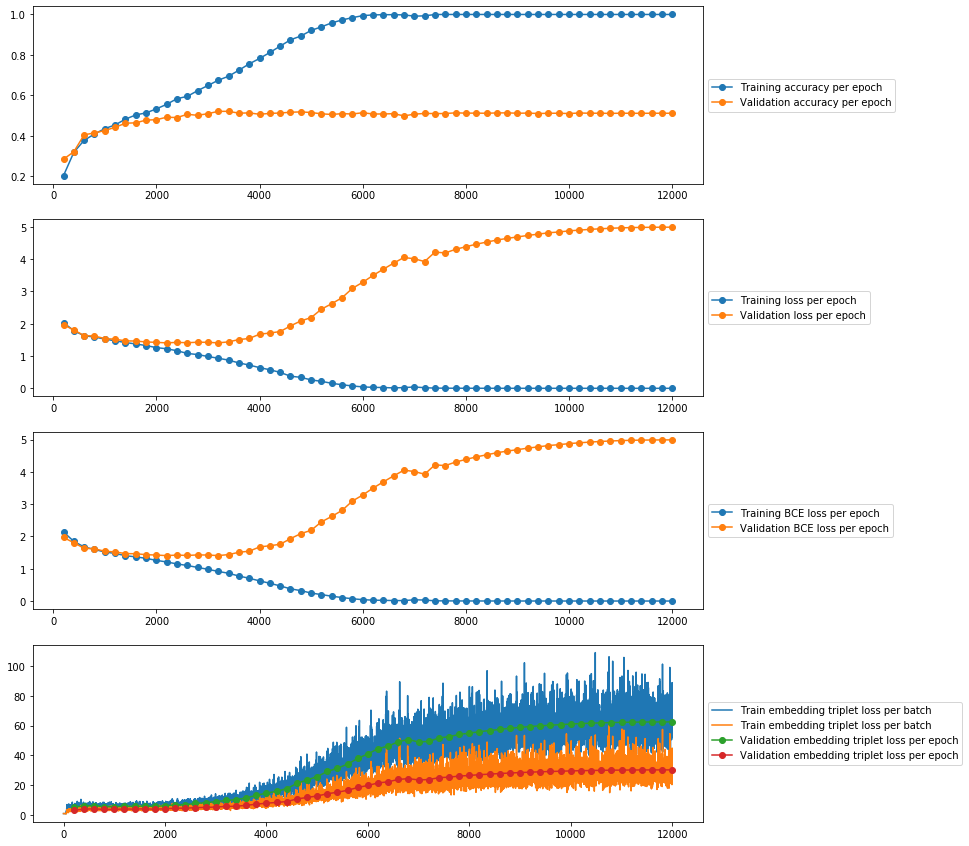

In [14]:
validator.plot()

In [15]:
print(np.max(validator.val_accuracies), " Best validation accuracy without reg")
print(np.max(validator.train_accuracies), " Best train accuracy without reg")

0.5215625  Best validation accuracy without reg
1.0  Best train accuracy without reg


resnet2 = torchvision.models.resnet18(pretrained=False)
num_ftrs = resnet2.fc.in_features
resnet2.fc = nn.Sequential()

model2 = SelectiveSequential(
    ['act1', 'act2', 'out'],
    {'conv32a': resnet2,
       
     'fc1': nn.Linear(num_ftrs, 1000),
     'act1': nn.ReLU(True),
     #'drop1': nn.Dropout(.05),
     'fc2': nn.Linear(1000, 1000),
     'act2': nn.ReLU(True),
     #'drop1': nn.Dropout(.05),
     'out': nn.Linear(1000, 10)})

In [24]:
model2 = SelectiveSequential(
    ['act1', 'act2', 'out'],
    {'conv32a': nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
     #'batch32a': nn.BatchNorm2d(32),
     'act32a': nn.ReLU(True),
    
     'conv32b': nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
     #'batch32b': nn.BatchNorm2d(32),
     'act32b': nn.ReLU(True),
     
     'max1': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'conv64a': nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
     #'batch64a': nn.BatchNorm2d(64),
     'act64a': nn.ReLU(True),
     
     'conv64b': nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
     #'batch64b': nn.BatchNorm2d(64),
     'act64b': nn.ReLU(True),
    
     'max2': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'conv128a': nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
     #'batch128a': nn.BatchNorm2d(128),
     'act128a': nn.ReLU(True),
     
     'conv128b': nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
     #'batch128b': nn.BatchNorm2d(128),
     'act128b': nn.ReLU(True),
     
     'max3': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'flatten': Flatten(),
    
     'fc1': nn.Linear(4 * 4 * 128, 512),
     'act1': nn.ReLU(True),
     #'drop1': nn.Dropout(.05),
     'fc2': nn.Linear(512, 256),
     'act2': nn.ReLU(True),
     #'drop1': nn.Dropout(.05),
     'out': nn.Linear(256, 10)})

In [25]:
criterion = TripletRegularizedCrossEntropyLoss(0.1, .5)

In [26]:
sess = Session(model2, criterion, optim.AdamW, 1e-4)

In [27]:
# lr_find(sess, trainloader, start_lr=1e-12)

In [28]:
# sess.set_lr(1e-2)

In [29]:
validator2 = EmbeddingSpaceValidator(valloader, 2, CustomOneHotAccuracy)
lr_scheduler2 = CosAnneal(len(trainloader) * 60, T_mult=1, lr_min=1e-7)
schedule2 = TrainingSchedule(trainloader, [validator2])
sess.train(schedule2, 60)

Validating: 100%|██████████| 200/200 [00:03<00:00, 53.23it/s]


val accuracy:  0.0966 
train loss:  2.403  train BCE :  2.3034 
valid loss:  2.4032  valid BCE :  2.3031


Validating: 100%|██████████| 200/200 [00:03<00:00, 59.06it/s]


val accuracy:  0.0966 
train loss:  2.4025  train BCE :  2.3027 
valid loss:  2.4029  valid BCE :  2.3029


Validating: 100%|██████████| 200/200 [00:03<00:00, 60.16it/s]


val accuracy:  0.1003 
train loss:  2.4026  train BCE :  2.3026 
valid loss:  2.403  valid BCE :  2.3029


Validating: 100%|██████████| 200/200 [00:03<00:00, 60.22it/s]


val accuracy:  0.1003 
train loss:  2.4028  train BCE :  2.3025 
valid loss:  2.403  valid BCE :  2.3029


Validating: 100%|██████████| 200/200 [00:03<00:00, 59.47it/s]


val accuracy:  0.1003 
train loss:  2.4026  train BCE :  2.3024 
valid loss:  2.403  valid BCE :  2.3029


Validating: 100%|██████████| 200/200 [00:03<00:00, 56.98it/s]


val accuracy:  0.1003 
train loss:  2.4032  train BCE :  2.3023 
valid loss:  2.403  valid BCE :  2.3029


Validating: 100%|██████████| 200/200 [00:03<00:00, 59.51it/s]


val accuracy:  0.1003 
train loss:  2.4027  train BCE :  2.3023 
valid loss:  2.4029  valid BCE :  2.3029


Validating: 100%|██████████| 200/200 [00:03<00:00, 58.64it/s]


val accuracy:  0.1003 
train loss:  2.4023  train BCE :  2.3024 
valid loss:  2.403  valid BCE :  2.3029


Validating: 100%|██████████| 200/200 [00:03<00:00, 58.18it/s]


val accuracy:  0.1033 
train loss:  2.4024  train BCE :  2.3023 
valid loss:  2.403  valid BCE :  2.3029


Validating: 100%|██████████| 200/200 [00:03<00:00, 59.09it/s]


val accuracy:  0.1 
train loss:  2.4028  train BCE :  2.3023 
valid loss:  2.4029  valid BCE :  2.3029


Validating: 100%|██████████| 200/200 [00:03<00:00, 51.61it/s]


val accuracy:  0.1003 
train loss:  2.4023  train BCE :  2.3022 
valid loss:  2.403  valid BCE :  2.3029


Validating: 100%|██████████| 200/200 [00:03<00:00, 53.89it/s]


val accuracy:  0.1 
train loss:  2.4026  train BCE :  2.3023 
valid loss:  2.403  valid BCE :  2.3029


Validating: 100%|██████████| 200/200 [00:03<00:00, 57.84it/s]


val accuracy:  0.1003 
train loss:  2.4021  train BCE :  2.3022 
valid loss:  2.403  valid BCE :  2.3029


Validating: 100%|██████████| 200/200 [00:03<00:00, 56.87it/s]


val accuracy:  0.1 
train loss:  2.4025  train BCE :  2.3022 
valid loss:  2.4029  valid BCE :  2.3028


Validating: 100%|██████████| 200/200 [00:03<00:00, 58.58it/s]


val accuracy:  0.1033 
train loss:  2.402  train BCE :  2.3021 
valid loss:  2.403  valid BCE :  2.3028


Validating: 100%|██████████| 200/200 [00:03<00:00, 57.66it/s]


val accuracy:  0.1736 
train loss:  2.4023  train BCE :  2.302 
valid loss:  2.4029  valid BCE :  2.3027


Validating: 100%|██████████| 200/200 [00:03<00:00, 57.32it/s]


val accuracy:  0.0992 
train loss:  2.4029  train BCE :  2.302 
valid loss:  2.4029  valid BCE :  2.3026


Validating: 100%|██████████| 200/200 [00:03<00:00, 59.66it/s]


val accuracy:  0.1639 
train loss:  2.4023  train BCE :  2.3018 
valid loss:  2.4029  valid BCE :  2.3023


Validating: 100%|██████████| 200/200 [00:03<00:00, 60.01it/s]



val accuracy:  0.2473 
train loss:  2.4009  train BCE :  2.3005 
valid loss:  2.4012  valid BCE :  2.2977


Validating: 100%|██████████| 200/200 [00:03<00:00, 56.29it/s]


val accuracy:  0.4361 
train loss:  2.0941  train BCE :  2.0076 
valid loss:  1.9812  valid BCE :  1.5965


Validating: 100%|██████████| 200/200 [00:03<00:00, 55.71it/s]


val accuracy:  0.5066 
train loss:  1.752  train BCE :  1.4533 
valid loss:  1.754  valid BCE :  1.3736


Validating: 100%|██████████| 200/200 [00:03<00:00, 59.97it/s]


val accuracy:  0.552 
train loss:  1.5923  train BCE :  1.2244 
valid loss:  1.6406  valid BCE :  1.2844


Validating: 100%|██████████| 200/200 [00:03<00:00, 59.51it/s]


val accuracy:  0.5766 
train loss:  1.4641  train BCE :  1.1142 
valid loss:  1.557  valid BCE :  1.182


Validating: 100%|██████████| 200/200 [00:03<00:00, 57.72it/s]



val accuracy:  0.5856 
train loss:  1.3664  train BCE :  1.0228 
valid loss:  1.5248  valid BCE :  1.1453


Validating: 100%|██████████| 200/200 [00:03<00:00, 58.07it/s]


val accuracy:  0.6008 
train loss:  1.261  train BCE :  0.9569 
valid loss:  1.4628  valid BCE :  1.1104


Validating: 100%|██████████| 200/200 [00:03<00:00, 58.26it/s]



val accuracy:  0.6242 
train loss:  1.2016  train BCE :  0.8928 
valid loss:  1.4118  valid BCE :  1.0544


Validating: 100%|██████████| 200/200 [00:03<00:00, 57.51it/s]


val accuracy:  0.6328 
train loss:  1.0982  train BCE :  0.8166 
valid loss:  1.3742  valid BCE :  1.0202


Validating: 100%|██████████| 200/200 [00:03<00:00, 57.98it/s]


val accuracy:  0.6281 
train loss:  1.0275  train BCE :  0.7631 
valid loss:  1.4004  valid BCE :  1.0325


Validating: 100%|██████████| 200/200 [00:03<00:00, 53.62it/s]


val accuracy:  0.643 
train loss:  0.9764  train BCE :  0.7087 
valid loss:  1.3803  valid BCE :  1.0169


Validating: 100%|██████████| 200/200 [00:03<00:00, 57.69it/s]


val accuracy:  0.6431 
train loss:  0.889  train BCE :  0.642 
valid loss:  1.3486  valid BCE :  0.9898


Validating: 100%|██████████| 200/200 [00:03<00:00, 58.44it/s]


val accuracy:  0.6409 
train loss:  0.8424  train BCE :  0.5956 
valid loss:  1.3589  valid BCE :  0.9908


Validating: 100%|██████████| 200/200 [00:03<00:00, 57.04it/s]


val accuracy:  0.6483 
train loss:  0.7779  train BCE :  0.5507 
valid loss:  1.3697  valid BCE :  0.9969


Validating: 100%|██████████| 200/200 [00:03<00:00, 53.94it/s]


val accuracy:  0.6573 
train loss:  0.7093  train BCE :  0.4988 
valid loss:  1.3945  valid BCE :  1.0046


Validating: 100%|██████████| 200/200 [00:03<00:00, 57.51it/s]


val accuracy:  0.6541 
train loss:  0.6708  train BCE :  0.4477 
valid loss:  1.4245  valid BCE :  1.0249


Validating: 100%|██████████| 200/200 [00:03<00:00, 58.98it/s]


val accuracy:  0.6516 
train loss:  0.61  train BCE :  0.4022 
valid loss:  1.4206  valid BCE :  1.0364


Validating: 100%|██████████| 200/200 [00:03<00:00, 59.61it/s]


val accuracy:  0.6555 
train loss:  0.5481  train BCE :  0.3526 
valid loss:  1.4111  valid BCE :  1.0247


Validating: 100%|██████████| 200/200 [00:03<00:00, 57.05it/s]


val accuracy:  0.6569 
train loss:  0.5038  train BCE :  0.3248 
valid loss:  1.4698  valid BCE :  1.0669


Validating: 100%|██████████| 200/200 [00:03<00:00, 57.38it/s]


val accuracy:  0.6486 
train loss:  0.4334  train BCE :  0.2775 
valid loss:  1.6063  valid BCE :  1.1604


Validating: 100%|██████████| 200/200 [00:03<00:00, 59.28it/s]


val accuracy:  0.6389 
train loss:  0.4023  train BCE :  0.2326 
valid loss:  1.6614  valid BCE :  1.2264


Validating: 100%|██████████| 200/200 [00:03<00:00, 52.87it/s]


val accuracy:  0.6506 
train loss:  0.3362  train BCE :  0.2002 
valid loss:  1.6222  valid BCE :  1.1833


Validating: 100%|██████████| 200/200 [00:03<00:00, 54.10it/s]



val accuracy:  0.6427 
train loss:  0.2962  train BCE :  0.1694 
valid loss:  1.6371  valid BCE :  1.2


Validating: 100%|██████████| 200/200 [00:03<00:00, 58.01it/s]


val accuracy:  0.6483 
train loss:  0.2672  train BCE :  0.1452 
valid loss:  1.6976  valid BCE :  1.2378


Validating: 100%|██████████| 200/200 [00:03<00:00, 55.35it/s]


val accuracy:  0.6552 
train loss:  0.2219  train BCE :  0.1133 
valid loss:  1.691  valid BCE :  1.2268


Validating: 100%|██████████| 200/200 [00:03<00:00, 56.95it/s]


val accuracy:  0.6644 
train loss:  0.1976  train BCE :  0.0871 
valid loss:  1.7655  valid BCE :  1.2784


Validating: 100%|██████████| 200/200 [00:03<00:00, 55.59it/s]


val accuracy:  0.6619 
train loss:  0.1696  train BCE :  0.0718 
valid loss:  1.7963  valid BCE :  1.3044


Validating: 100%|██████████| 200/200 [00:03<00:00, 59.59it/s]


val accuracy:  0.6539 
train loss:  0.1453  train BCE :  0.0556 
valid loss:  1.8215  valid BCE :  1.3324


Validating: 100%|██████████| 200/200 [00:03<00:00, 57.78it/s]


val accuracy:  0.6547 
train loss:  0.1195  train BCE :  0.0453 
valid loss:  1.8389  valid BCE :  1.3551


Validating: 100%|██████████| 200/200 [00:03<00:00, 57.35it/s]


val accuracy:  0.6586 
train loss:  0.0989  train BCE :  0.035 
valid loss:  1.8722  valid BCE :  1.3727


Validating: 100%|██████████| 200/200 [00:03<00:00, 57.78it/s]


val accuracy:  0.6566 
train loss:  0.0805  train BCE :  0.024 
valid loss:  1.9778  valid BCE :  1.4483


Validating: 100%|██████████| 200/200 [00:03<00:00, 57.68it/s]


val accuracy:  0.6511 
train loss:  0.0674  train BCE :  0.0187 
valid loss:  2.0286  valid BCE :  1.4984


Validating: 100%|██████████| 200/200 [00:03<00:00, 57.34it/s]


val accuracy:  0.6481 
train loss:  0.0586  train BCE :  0.0158 
valid loss:  2.0693  valid BCE :  1.5261


Validating: 100%|██████████| 200/200 [00:03<00:00, 56.74it/s]


val accuracy:  0.6527 
train loss:  0.0484  train BCE :  0.0118 
valid loss:  2.0918  valid BCE :  1.5497


Validating: 100%|██████████| 200/200 [00:03<00:00, 57.81it/s]


val accuracy:  0.655 
train loss:  0.0438  train BCE :  0.0116 
valid loss:  2.1114  valid BCE :  1.5607


Validating: 100%|██████████| 200/200 [00:03<00:00, 58.45it/s]


val accuracy:  0.6484 
train loss:  0.0411  train BCE :  0.0084 
valid loss:  2.2387  valid BCE :  1.6616


Validating: 100%|██████████| 200/200 [00:03<00:00, 57.48it/s]


val accuracy:  0.6453 
train loss:  0.0308  train BCE :  0.0069 
valid loss:  2.2382  valid BCE :  1.6557


Validating: 100%|██████████| 200/200 [00:03<00:00, 58.17it/s]


val accuracy:  0.6502 
train loss:  0.0255  train BCE :  0.0048 
valid loss:  2.233  valid BCE :  1.6597


Validating: 100%|██████████| 200/200 [00:03<00:00, 56.37it/s]


val accuracy:  0.6489 
train loss:  0.0236  train BCE :  0.0039 
valid loss:  2.2619  valid BCE :  1.6778


Validating: 100%|██████████| 200/200 [00:03<00:00, 56.04it/s]


val accuracy:  0.6447 
train loss:  0.0224  train BCE :  0.0037 
valid loss:  2.3303  valid BCE :  1.744


Validating: 100%|██████████| 200/200 [00:03<00:00, 55.93it/s]


val accuracy:  0.6384 
train loss:  0.0238  train BCE :  0.0043 
valid loss:  2.5611  valid BCE :  1.9532


Validating: 100%|██████████| 200/200 [00:03<00:00, 60.13it/s]


val accuracy:  0.593 
train loss:  0.1347  train BCE :  0.0481 
valid loss:  2.6985  valid BCE :  2.1483



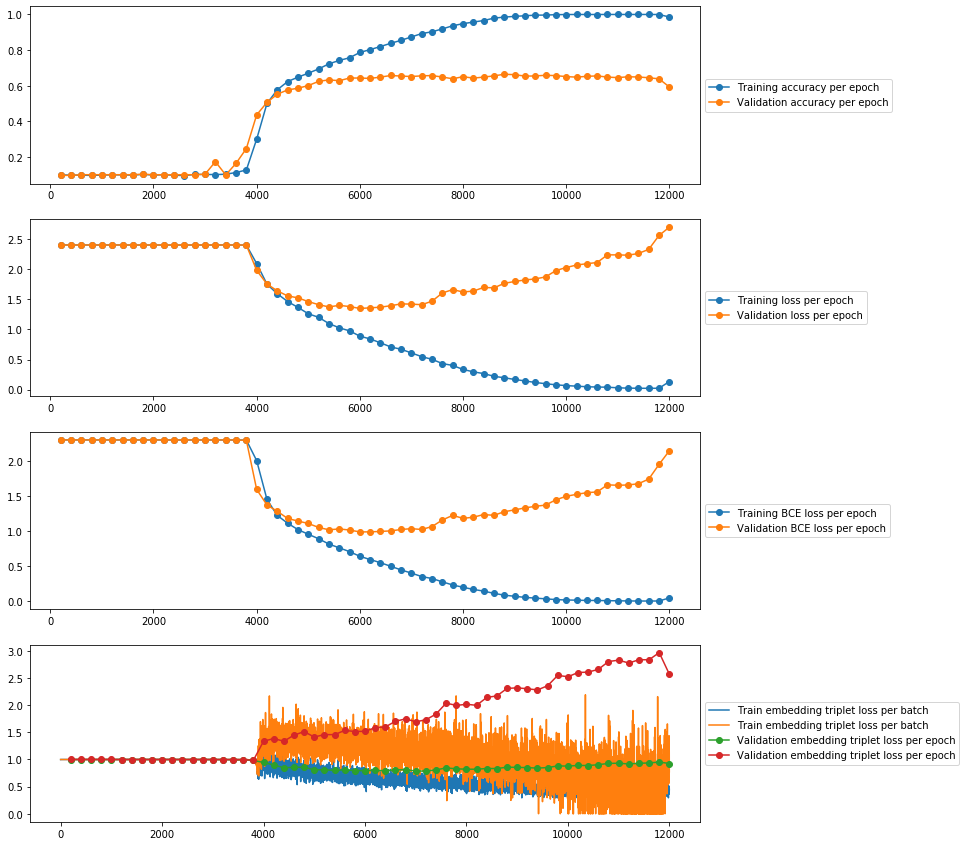

In [30]:
validator2.plot()

In [23]:
print(np.max(validator2.val_accuracies), "Best accuracy with reg")
print(np.max(validator.val_accuracies), "Best accuracy without reg")

0.10328125 Best accuracy with reg
0.5215625 Best accuracy without reg
